# **Import Libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import text
from sklearn.metrics import classification_report

from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.style import set_palette
from yellowbrick.text import FreqDistVisualizer

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
train = pd.read_csv('../input/60k-stack-overflow-questions-with-quality-rate/train.csv')
validation = pd.read_csv('../input/60k-stack-overflow-questions-with-quality-rate/valid.csv')

In [4]:
train.head(5)

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ


# **Target Variable**

We have a multiclass problem with 3 classes. Classes looks balanced.

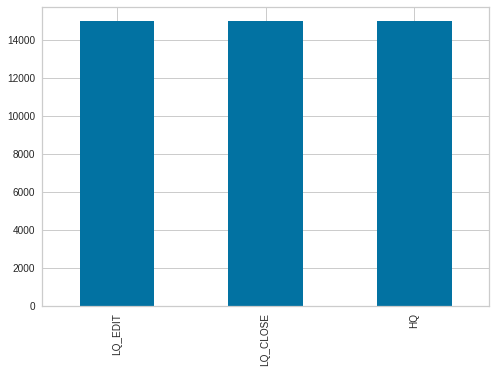

In [5]:
train.Y.value_counts().plot.bar()

# **HTML To Text**

Let's convert data from html to text using BeautifulSoup python module. This will remove special html tags as shown below Body and Text columns.

In [6]:
train['Text']=train.Body.apply(lambda x: BeautifulSoup(x, 'html.parser').text)
validation['Text']=validation.Body.apply(lambda x: BeautifulSoup(x, 'html.parser').text)
train.head(5)

,Id,Title,Body,Tags,CreationDate,Y,Text
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,I'm already familiar with repeating tasks ever...
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ,I'd like to understand why Java 8 Optionals we...
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,I am attempting to overlay a title over an ima...
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,"The question is very simple, but I just could ..."
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ,I'm using custom floatingactionmenu. I need to...


# **Lower Case The Text**

In [7]:
train['Text']=train['Text'].str.lower()
validation['Text']=validation['Text'].str.lower()
train.head(5)

,Id,Title,Body,Tags,CreationDate,Y,Text
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,i'm already familiar with repeating tasks ever...
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ,i'd like to understand why java 8 optionals we...
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,i am attempting to overlay a title over an ima...
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,"the question is very simple, but i just could ..."
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ,i'm using custom floatingactionmenu. i need to...


# **Document Word Counts Distribution**

In [8]:
MAX_FEATURES = 20000
MAX_LEN = 200

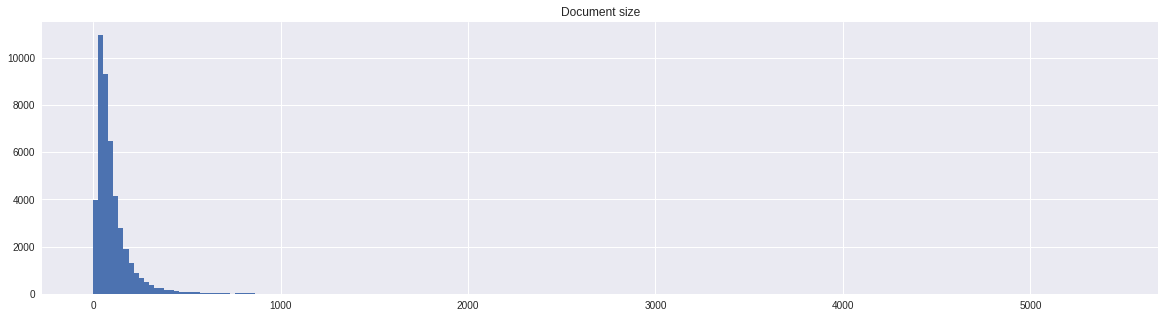

max length: 5412 / min length: 0 / mean length: 106 / limit length: 200


In [9]:
X=train['Text'].values

plt.style.use('seaborn')

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index

result = [len(x.split()) for x in X]


plt.figure(figsize=(20,5))
plt.title('Document size')
plt.hist(result, 200, density=False, range=(0,np.max(result)))
plt.show()


print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result), np.min(result), np.mean(result), MAX_LEN))


# **Token Frequency Distribution**

/opt/conda/lib/python3.7/site-packages/yellowbrick/text/freqdist.py:268: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  self.ax.bar(bins, freq, label=label, color=self.color, align="edge")


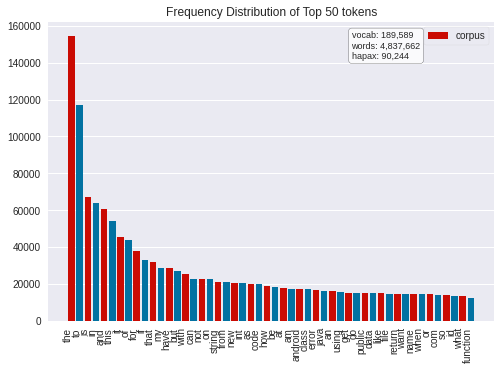

In [10]:
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(X)
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v',color='rb')
visualizer.fit(docs)
visualizer.show()

### Simple Text Correlation Test with Title

In [11]:
text_df = train[['Title','Y']].sample(frac=0.1)
codes, uniques = pd.factorize(text_df.Y)
text_df['Y'] = codes
text_df['Title'] = text_df.Title.str.replace('\(|\)|,|\.|\"','')
s_corr = text_df.Title.str.lower().str.get_dummies(sep=' ').corrwith(text_df.Y/text_df.Y.max())

In [12]:
s_corr.sort_values(ascending=False)[:5]

react         0.136423
native        0.090824
component     0.079760
typescript    0.077301
angular       0.074059
dtype: float64

In [13]:
s_corr.sort_values(ascending=True)[:5]

i      -0.149011
help   -0.134032
sql    -0.127306
this   -0.102543
my     -0.092369
dtype: float64

# **Model Settings**

In [14]:
EPOCHS = 15
BATCH_SIZE = 24
#MAX_LEN = 192

# **Encode Target Variable to Binary Categorical**

In [15]:
encoder = LabelEncoder()
encoder.fit(train.Y.values)
encoded_Y_train = encoder.transform(train.Y.values)
encoded_Y_valid = encoder.transform(validation.Y.values)


x_train = train.Text.values
x_valid = validation.Text.values


y_train = np_utils.to_categorical(encoded_Y_train)
y_valid = np_utils.to_categorical(encoded_Y_valid)

# **Tokenize Words and Pad Max Sequences**

In [16]:
tokens=text.Tokenizer(num_words=MAX_FEATURES, lower=True)
tokens.fit_on_texts(list(x_train))

In [17]:
x_train=tokens.texts_to_sequences(x_train)
x_valid=tokens.texts_to_sequences(x_valid)


x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_valid = tf.keras.preprocessing.sequence.pad_sequences(x_valid, maxlen=MAX_LEN)

# **Model**

# **LSTM MODEL**


In [18]:
inputs = tf.keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(MAX_FEATURES, 128)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Dense(32, activation='swish')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

# **CNN MODEL**

This is for demonstration only how to implement Text Classification in CNN.

In [19]:
inputs_cnn = tf.keras.Input(shape=(None,), dtype="int32")
x_cnn = layers.Embedding(MAX_FEATURES, 128)(inputs_cnn)
x_cnn = layers.Bidirectional(layers.GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x_cnn)
x_cnn = layers.Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x_cnn)
avg_pool = layers.GlobalAveragePooling1D()(x_cnn)
max_pool = layers.GlobalMaxPooling1D()(x_cnn)
x_cnn = layers.concatenate([avg_pool, max_pool])

outputs_cnn = layers.Dense(3, activation="softmax")(x_cnn)
model_cnn = tf.keras.Model(inputs_cnn, outputs_cnn)
model_cnn.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    2560000     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, None, 256)    198144      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 64)     49216       bidirectional_2[0][0]            
_______________________________________________________________________________________

In [20]:
SGD=tf.keras.optimizers.SGD(learning_rate=0.01)
Adam=tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',optimizer=SGD,metrics=[tf.keras.metrics.AUC()])
#model.compile(loss='categorical_crossentropy',optimizer=Adam,metrics=[tf.keras.metrics.AUC()])

# **Train Model**

# **Callbacks**

In [21]:
es_cb = EarlyStopping(monitor='val_acc', min_delta=0, restore_best_weights=True, patience=5, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=3, min_lr=0.001)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.01)

In [22]:
'''
checkpoint_filepath = 'checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
'''

"\ncheckpoint_filepath = 'checkpoint'\n\nmodel_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(\n    filepath=checkpoint_filepath,\n    save_weights_only=True,\n    monitor='val_accuracy',\n    mode='max',\n    save_best_only=True)\n"

In [23]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_valid, y_valid),callbacks = [es_cb,reduce_lr], verbose=1)

Epoch 1/15
1875/1875 [==============================] - 75s 40ms/step - loss: 1.0940 - auc: 0.5721 - val_loss: 1.0826 - val_auc: 0.6956
Epoch 2/15
1875/1875 [==============================] - 74s 39ms/step - loss: 0.8052 - auc: 0.8108 - val_loss: 0.6129 - val_auc: 0.8793
Epoch 3/15
1875/1875 [==============================] - 76s 40ms/step - loss: 0.6297 - auc: 0.8710 - val_loss: 0.6619 - val_auc: 0.8732
Epoch 4/15
1875/1875 [==============================] - 75s 40ms/step - loss: 0.5969 - auc: 0.8885 - val_loss: 0.5573 - val_auc: 0.9101
Epoch 5/15
1875/1875 [==============================] - 76s 40ms/step - loss: 0.7262 - auc: 0.8447 - val_loss: 1.0201 - val_auc: 0.8104
Epoch 6/15
1875/1875 [==============================] - 77s 41ms/step - loss: 0.6764 - auc: 0.8597 - val_loss: 0.6147 - val_auc: 0.8858
Epoch 7/15
1875/1875 [==============================] - 77s 41ms/step - loss: 0.6345 - auc: 0.8807 - val_loss: 0.5728 - val_auc: 0.9045
Epoch 8/15
1875/1875 [==========================

In [24]:
#model.load_weights(checkpoint_filepath)

# **Model Performance**

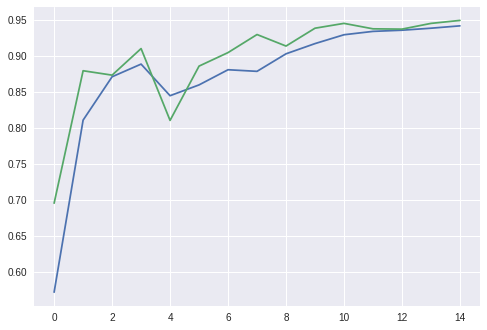

In [25]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])

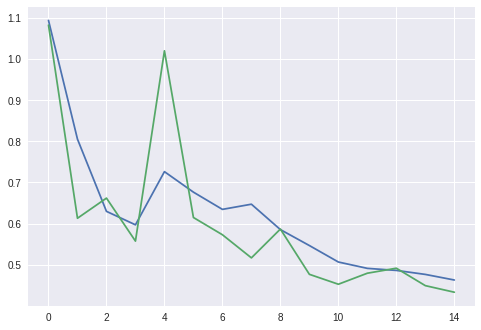

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# **Testing Model**

A random question from https://stackoverflow.com/questions/tagged/java

In [27]:
#test_question = ['I have sql server management studio 14.0.17825.0 and would like to use group_concat function. But I get error when i try to use. The error is invalid column name group_concat Is there any other function that I could use? Could you provide a sample code which could achieve what function group_concat?']
test_question  = ['If I have an object implementing the Map interface in Java and I wish to iterate over every pair contained within it, what is the most efficient way of going through the map? Will the ordering of elements depend on the specific map implementation that I have for the interface?']

In [28]:
seq = tokenizer.texts_to_sequences(test_question)
padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MAX_LEN)
pred = model.predict(padded)

In [29]:
labels=list(encoder.classes_)
print(np.argmax(pred), labels[np.argmax(pred)])

1 LQ_CLOSE


# **Prediction Test**

This part is to show how to use prediction and classificaion report. In normal cases, it's not right to use validation data for this purpose. We need another dataset that model never seen before.


In [30]:
y_pred=model.predict(x_valid)
y_pred=np.argmax(y_pred,axis=1)

In [31]:
y_true=np.argmax(y_valid,axis=1)

In [32]:
target_names = list(encoder.classes_)

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          HQ       0.78      0.78      0.78      5000
    LQ_CLOSE       0.73      0.77      0.75      5000
     LQ_EDIT       0.98      0.92      0.95      5000

    accuracy                           0.82     15000
   macro avg       0.83      0.82      0.83     15000
weighted avg       0.83      0.82      0.83     15000

